In [194]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import plotly.express as px
import time
import geopy.distance
from geopy.geocoders import Nominatim
import geocoder 
from sklearn.base import TransformerMixin, BaseEstimator
from collections import Counter
import scipy.stats as stats
import category_encoders as ce
#from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
from sklearn import metrics 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [195]:
df = pd.read_csv('data/country_houses.csv')
print(df.shape)
df.head()


(3052, 53)


,Unnamed: 0,index,Тип объекта,Площадь участка,Площадь общая,Площадь жилая,Уровней в доме,Год постройки,Процент готовности,Материал стен,...,Камин,Строительные материалы,Район города,Беседка,Микрорайон,Новостройка,Бассейн,Элитный коттедж,Пруд на участке,Аукцион
0,0,3289189,['Дача'],"['10.38', 'соток']","['16.7', 'м²']","['12', 'м²']",['1'],['2000'],['100'],['Дерево'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,3045903,['Дача'],"['7.55', 'соток']","['60.2', 'м²']","['43.1', 'м²']",['2'],['1991'],NaN,"['Блок', 'газосиликатный']",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,3292051,['Дача'],"['5', 'соток']","['80.8', 'м²']","['60', 'м²']",['3'],NaN,['100'],"['Красный', 'кирпич']",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2921238,['Дача'],"['4.3', 'сотки']","['29.6', 'м²']",NaN,['1'],['1994'],NaN,['Дерево'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,3152945,['Дача'],"['7', 'соток']","['10', 'м²']",NaN,['1'],['1995'],NaN,['Блочный'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [196]:
print(f"Duplicates found: {df[df.duplicated].shape[0]}")

df = df.drop_duplicates().drop('Unnamed: 0', axis=1)
df.shape

Duplicates found: 0


(3052, 52)

In [197]:
print(f"nan in price column: {df['Цена'].isna().sum()}")
df = df[df['Цена'].notna()]
df.shape

nan in price column: 109


(2943, 52)

In [198]:
df.columns


Index(['index', 'Тип объекта', 'Площадь участка', 'Площадь общая',
       'Площадь жилая', 'Уровней в доме', 'Год постройки',
       'Процент готовности', 'Материал стен', 'Материал крыши', 'Отопление',
       'Канализация', 'Электроснабжение', 'Вода', 'Телефон', 'Условия продажи',
       'Номер договора', 'Область', 'Район', 'Населенный пункт', 'Номер дома',
       'Сельсовет', 'Координаты', 'Цена', 'Площадь кухни', 'Газ', 'Баня',
       'Гараж', 'Статус земли', 'Сад', 'Хозпостройки', 'Возможен торг',
       'Рядом лес', 'Водоем', 'Ландшафтный дизайн', 'Улица',
       'Ширина застройки', 'Длина застройки', 'Теплица', 'Мебель',
       'Направление', 'Ремонт', 'Камин', 'Строительные материалы',
       'Район города', 'Беседка', 'Микрорайон', 'Новостройка', 'Бассейн',
       'Элитный коттедж', 'Пруд на участке', 'Аукцион'],
      dtype='object')

In [199]:
df.drop(['Тип объекта', 'Номер договора', 'Возможен торг', 'Номер дома', 'Условия продажи', 'Аукцион'], axis=1, inplace=True)

In [200]:
class NUM_Transformer(TransformerMixin, BaseEstimator):
    '''Transform numeric features'''

    def __init__(self):
        pass


    def fit(self, X, y=None):
        '''
        '''
        return self


    def transform(self,X):
        ''''''
        X['land_area'] = X['Площадь участка'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['house_area'] = X['Площадь общая'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['house_levels'] = X['Уровней в доме'].apply(lambda x: int(re.findall(r"\d{1}", x)[0]) if x is not np.nan else x)
        X['house_year'] = X['Год постройки'].apply(lambda x: int(re.findall(r"\d{4}", x)[0]) if x is not np.nan else x)
        X['house_readiness'] = X['Процент готовности'].apply(lambda x: int(re.findall(r"\d{2,}", x)[0]) if x is not np.nan else x)
        X['house_coordinates'] = X['Координаты'].apply(
            lambda x: (float(re.findall(r"\d{2}\.\d{2,}", x)[0]),float(re.findall(r"\d{2}\.\d{2,}", x)[1])) if x is not np.nan else x)
        X['price'] = X['Цена'].apply(lambda x: float(x.split()[0] + x.split()[1]) if x is not np.nan else x)
        X['liv_house_area'] = X['Площадь жилая'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['kitchen_area'] = X['Площадь кухни'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['house_width'] = X['Ширина застройки'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['house_length'] = X['Длина застройки'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        
        X.drop(['Площадь участка', 'Площадь общая', 'Уровней в доме', 'Год постройки', 'Процент готовности', 'Координаты', 'Цена',
              'Площадь жилая', 'Площадь кухни', 'Ширина застройки', 'Длина застройки'], axis=1, inplace=True)

        X = X.fillna({
            'kitchen_area': X['kitchen_area'].median(),
            'house_readiness': X['house_readiness'].median(),
            'liv_house_area': X['liv_house_area'].median(),
            'house_area': X['house_area'].median(), 
            'land_area': X['land_area'].median(),
            'house_coordinates': X['house_coordinates'].fillna(df.groupby('Населенный пункт')['house_coordinates'].transform(
                lambda x: str(x.value_counts().index[0]) if len(x.value_counts().index)>0 else np.nan))
        })

        X = X[X['house_coordinates'].notna()]        
        

        return X
    

num_treat = NUM_Transformer()
df = num_treat.transform(df)

In [201]:
cat_features = ['Материал стен', 'Отопление', 'Вода', 'Область', 'Район',
       'Населенный пункт', 'Сельсовет', 'Электроснабжение', 'Баня',
       'Материал крыши', 'Канализация', 'Статус земли', 'Камин', 'Гараж', 'Направление', 'Мебель', 'Газ',
       'Ремонт', 'Телефон', 'Новостройка', 'Улица', 'Район города','index', 'Водоем', 'Ландшафтный дизайн', 'Пруд на участке', 'Рядом лес',
       'Сад', 'Теплица', 'Хозпостройки', 'Беседка', 'Строительные материалы',
       'Бассейн', 'Элитный коттедж', 'Микрорайон', 'house_levels',
       'house_year']
num_features = ['land_area', 'house_area','house_readiness', 'latitude', 'longitude', 'price',
       'liv_house_area', 'kitchen_area', 'house_width', 'house_length']


In [202]:
categories = df[cat_features].nunique().sort_values(ascending=False)
display(categories)

index                     2942
Населенный пункт          1566
Сельсовет                  340
Направление                323
Улица                      217
Район                       91
house_year                  74
Материал стен               19
Микрорайон                  18
Материал крыши              13
Вода                        10
Отопление                   10
Район города                 8
Область                      6
Канализация                  5
Электроснабжение             5
Ремонт                       5
Статус земли                 4
house_levels                 4
Газ                          3
Телефон                      2
Новостройка                  1
Мебель                       1
Водоем                       1
Ландшафтный дизайн           1
Пруд на участке              1
Рядом лес                    1
Сад                          1
Теплица                      1
Хозпостройки                 1
Беседка                      1
Строительные материалы       1
Бассейн 

In [203]:
df.isna().sum().sort_values(ascending=False)

Элитный коттедж           2928
Бассейн                   2905
Новостройка               2874
Пруд на участке           2871
Микрорайон                2870
Телефон                   2858
Район города              2821
Строительные материалы    2814
Камин                     2611
Улица                     2611
Беседка                   2597
Гараж                     2528
Теплица                   2487
Баня                      2476
house_length              2398
Ремонт                    2382
house_width               2373
Мебель                    2219
Сад                       2067
Направление               1939
Водоем                    1924
Хозпостройки              1823
Ландшафтный дизайн        1767
Рядом лес                 1456
Газ                       1339
Канализация                966
house_year                 865
Сельсовет                  833
Отопление                  720
Материал крыши             691
house_levels               577
Вода                       404
Электрос

### Binary categories

In [204]:
bin_categories = categories[categories<=2]  
print(bin_categories)

Телефон                   2
Новостройка               1
Мебель                    1
Водоем                    1
Ландшафтный дизайн        1
Пруд на участке           1
Рядом лес                 1
Сад                       1
Теплица                   1
Хозпостройки              1
Беседка                   1
Строительные материалы    1
Бассейн                   1
Элитный коттедж           1
Гараж                     1
Камин                     1
Баня                      1
dtype: int64


In [205]:
display(df['Беседка'].value_counts())
display(df['Камин'].value_counts())
display(df['Телефон'].value_counts())

Беседка
1.0    345
Name: count, dtype: int64

Камин
['Да']    331
Name: count, dtype: int64

Телефон
['Есть']             83
['2', 'телефона']     1
Name: count, dtype: int64

In [206]:
class BIN_Transformer(TransformerMixin, BaseEstimator):
    '''Transform binary categories'''

    def __init__(self, bin_categories):
        self.categories = bin_categories
        

    def fit(self, X, y=None):
        '''
        '''
        return self


    def transform(self,X):
        ''''''
        for item in self.categories.index:
            X[item] = X[item].apply(lambda x: 0 if pd.isna(x) else 1)     
        
        return X
    

bin_treat = BIN_Transformer(bin_categories)
df = bin_treat.transform(df)

In [207]:
def draw_categories(features, ax_width=10, tick_rotation=30):
    n = len(features) 
    fig, axes = plt.subplots(n, 2, figsize=(ax_width, n*3)) 

    for i, feature in enumerate(features):
        #print(n,i,feature)
        count_data = (df[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
        sns.barplot(data=count_data, x=feature, y='percentage', ax=axes[i][0], width=0.4).set(title=f'{feature} (ratio)', xlabel='');
        axes[i][0].xaxis.set_tick_params(rotation=tick_rotation)
        sns.barplot(df, x=feature, y='price', ax=axes[i][1], width=0.4).set(title=f'{feature} (price)', xlabel='');
        axes[i][1].xaxis.set_tick_params(rotation=tick_rotation)
    plt.tight_layout() 
    
#draw_categories(bin_categories.index, tick_rotation=0)

### Multi options categories 

In [208]:
multi_categories = categories[categories>2]
display(multi_categories)


index               2942
Населенный пункт    1566
Сельсовет            340
Направление          323
Улица                217
Район                 91
house_year            74
Материал стен         19
Микрорайон            18
Материал крыши        13
Вода                  10
Отопление             10
Район города           8
Область                6
Канализация            5
Электроснабжение       5
Ремонт                 5
Статус земли           4
house_levels           4
Газ                    3
dtype: int64

In [209]:
df[multi_categories.index].isna().sum().sort_values(ascending=False) #/ df.shape[0]

Микрорайон          2870
Район города        2821
Улица               2611
Ремонт              2382
Направление         1939
Газ                 1339
Канализация          966
house_year           865
Сельсовет            833
Отопление            720
Материал крыши       691
house_levels         577
Вода                 404
Электроснабжение     384
Статус земли         372
Материал стен        344
Район                  5
Область                0
Населенный пункт       0
index                  0
dtype: int64

In [210]:
df = df.drop(['Микрорайон', 'Район города', 'Улица', 'index'], axis=1)

In [211]:
alpha = 0.05

def stat_compare(category, category_opt_1, category_opt_2, alpha=alpha):
    '''Assessment if the difference between feature options is statistically significant '''
    
    opt_1 = df[df[category]==category_opt_1]['price']
    opt_2 = df[df[category]==category_opt_2]['price']
    max_opt = df[df[category].isin([category_opt_1,category_opt_2])][category].value_counts().idxmax()

    def get_normality(data, alpha=alpha):
        _, p = stats.shapiro(data)
        if p <= alpha:
            return 1
        else:
            return 0
    
    def test_t(data_1, data_2, alpha=alpha):
        result = stats.levene(data_1, data_2)
        p = result[1]
        if p <= alpha:
            equal_var=False
        else:
            equal_var=True

        _, p = stats.ttest_ind(data_1, data_2, alternative='two-sided', equal_var=True)
        if p <= alpha:
            return 'not equal'
        else:
            return 'equal'


    def test_mannwhit(data_1, data_2, alpha=alpha):
        _, p = stats.mannwhitneyu(data_1, data_2, alternative='two-sided')
        if p <= alpha:
            return 'not equal'
        else:
            return 'equal'
    
    norm_1 = get_normality(opt_1)
    norm_2 = get_normality(opt_2)

    if norm_1==0 and norm_2==0:
        res = test_t(opt_1,opt_2)
        if res == 'equal':
            return f"{category_opt_1} ({get_normality(opt_1)}), {category_opt_2} ({get_normality(opt_2)}): {res} --> {max_opt}"
        else:
            return f"{category_opt_1} ({get_normality(opt_1)}), {category_opt_2} ({get_normality(opt_2)}): {res}"
    else:
        res = test_mannwhit(opt_1,opt_2)
        if res == 'equal':
            return f"{category_opt_1} ({get_normality(opt_1)}), {category_opt_2} ({get_normality(opt_2)}): {res} --> {max_opt}"
        else:
            return f"{category_opt_1} ({get_normality(opt_1)}), {category_opt_2} ({get_normality(opt_2)}): {res}" 
    

In [212]:
# fillna
fill_na_net = ['Электроснабжение', 'Вода', 'Отопление', 'Канализация', 'Газ', 'Ремонт']
fill_na_mode = ['Материал крыши', 'house_levels', 'Статус земли', 'Материал стен']
fill_na_find = ['Направление', 'Сельсовет', 'Район', 'Область', 'house_year']


In [214]:
df['Ремонт'].value_counts()

Ремонт
['Отделка', 'деревом']                       421
['Не', 'достроен']                            75
['Евроотделка']                               34
['Евроотделка,', 'отделка', 'деревом']        20
['Не', 'достроен,', 'отделка', 'деревом']     10
Name: count, dtype: int64

In [216]:
print(stat_compare('Канализация', "['С/у', 'на', 'улице']", "['Нет']"))
print(stat_compare('Канализация', "['Местная']", "['Центральная']"))
print(stat_compare('Электроснабжение', "['Рядом']", "['Нет']"))

print(stat_compare('Вода', "['Рядом', 'колодец']", "['Рядом']"))
print(stat_compare('Вода', "['Рядом', 'водопровод']", "['Рядом']"))
print(stat_compare('Вода', "['Нет']", "['Рядом']"))

print(stat_compare('Ремонт', "['Евроотделка,', 'отделка', 'деревом']", "['Евроотделка']"))
print(stat_compare('Ремонт', "['Не', 'достроен,', 'отделка', 'деревом']", "['Не', 'достроен']"))

print(stat_compare('Отопление', "['На', 'газу']", "['Паровое']"))
print(stat_compare('Отопление', "['Паровое', 'на', 'твёрдом', 'топливе']", "['Паровое']"))
print(stat_compare('Отопление', "['Паровое', 'на', 'жидком', 'топливе']", "['Паровое']"))

['С/у', 'на', 'улице'] (1), ['Нет'] (1): equal --> ['С/у', 'на', 'улице']
['Местная'] (1), ['Центральная'] (0): equal --> ['Местная']
['Рядом'] (1), ['Нет'] (1): not equal
['Рядом', 'колодец'] (1), ['Рядом'] (1): not equal
['Рядом', 'водопровод'] (1), ['Рядом'] (1): not equal
['Нет'] (1), ['Рядом'] (1): equal --> ['Рядом']
['Евроотделка,', 'отделка', 'деревом'] (0), ['Евроотделка'] (1): equal --> ['Евроотделка']
['Не', 'достроен,', 'отделка', 'деревом'] (1), ['Не', 'достроен'] (1): equal --> ['Не', 'достроен']
['На', 'газу'] (1), ['Паровое'] (0): not equal
['Паровое', 'на', 'твёрдом', 'топливе'] (1), ['Паровое'] (0): equal --> ['Паровое', 'на', 'твёрдом', 'топливе']
['Паровое', 'на', 'жидком', 'топливе'] (0), ['Паровое'] (0): equal --> ['Паровое', 'на', 'жидком', 'топливе']


In [ ]:
--

In [ ]:
class CAT_1_Transformer(TransformerMixin, BaseEstimator):
    '''Transform categories with multiple values, supposed to be fillna with "no" '''

    def __init__(self, fillna_cats):
        self.categories = fillna_cats
     
    def fit(self, X, y=None):
        ''''''
        return self

    def transform(self,X):
        ''''''
        X['Газ'] = X['Газ'].map({
            "['Рядом']":'рядом', 
            "['Есть']":'есть', 
            "['Нет']":'нет'
            }) 

        X['Канализация'] = X['Канализация'].map({
            "['С/у', 'на', 'улице']":'с/у снаружи', 
            "['Местная']":'местная', 
            "['Есть']":'есть', 
            "['Центральная']":'центральн', 
            "['Нет']":'нет',
            })

        X['Электроснабжение'] = X['Электроснабжение'].map({
            "['Есть']":'220В', 
            "['220В']":'220В', 
            "['Рядом']":'рядом', 
            "['380В']":'380В', 
            "['Нет']":'нет',
            })

        X['Отопление'] = X['Отопление'].map({
            "['Печное']":'печь', 
            "['Нет']":'нет', 
            "['На', 'газу']":'паровое г.', 
            "['Паровое', 'на', 'твёрдом', 'топливе']":'паровое т.', 
            "['Электрическое']":'электрич.',
            "['Паровое', 'на', 'жидком', 'топливе']":'паровое ж.',
            "['Паровое']":'паровое',
            "['Альтернативные', 'источники']":'альтерн.',
            "['Центральное']":'центральн.',
            "['Паровое', 'на', 'газу']":'паровое г.',
            })
        
        X['Вода'] = X['Вода'].map({
            "['Сезонная']":'сезонная', 
            "['Скважина']":'скважина', 
            "['Колодец']":'колодец', 
            "['Центральный', 'водопровод']":'центральн.',
            "['Холодная']":'холодная',
            "['Рядом', 'колодец']":'рядом колодец',
            "['Рядом']":'рядом',
            "['Горячая']":'горячая',
            "['Нет']":'нет',
            "['Рядом', 'водопровод']":'рядом водопр'
            })

        X['Ремонт'] = X['Ремонт'].map({
            "['Отделка', 'деревом']":'отделка дер.', 
            "['Не', 'достроен']":'не достроен',
            "['Евроотделка']":'евроотделка',
            "['Евроотделка,', 'отделка', 'деревом']":'евроотделка дер.',
            "['Не', 'достроен,', 'отделка', 'деревом']":'не достроен дер',
            })


        X[self.categories] = X[self.categories].fillna('нет')

        return X
    

cat_1_treat = CAT_1_Transformer(fill_na_net)
df = cat_1_treat.transform(df)

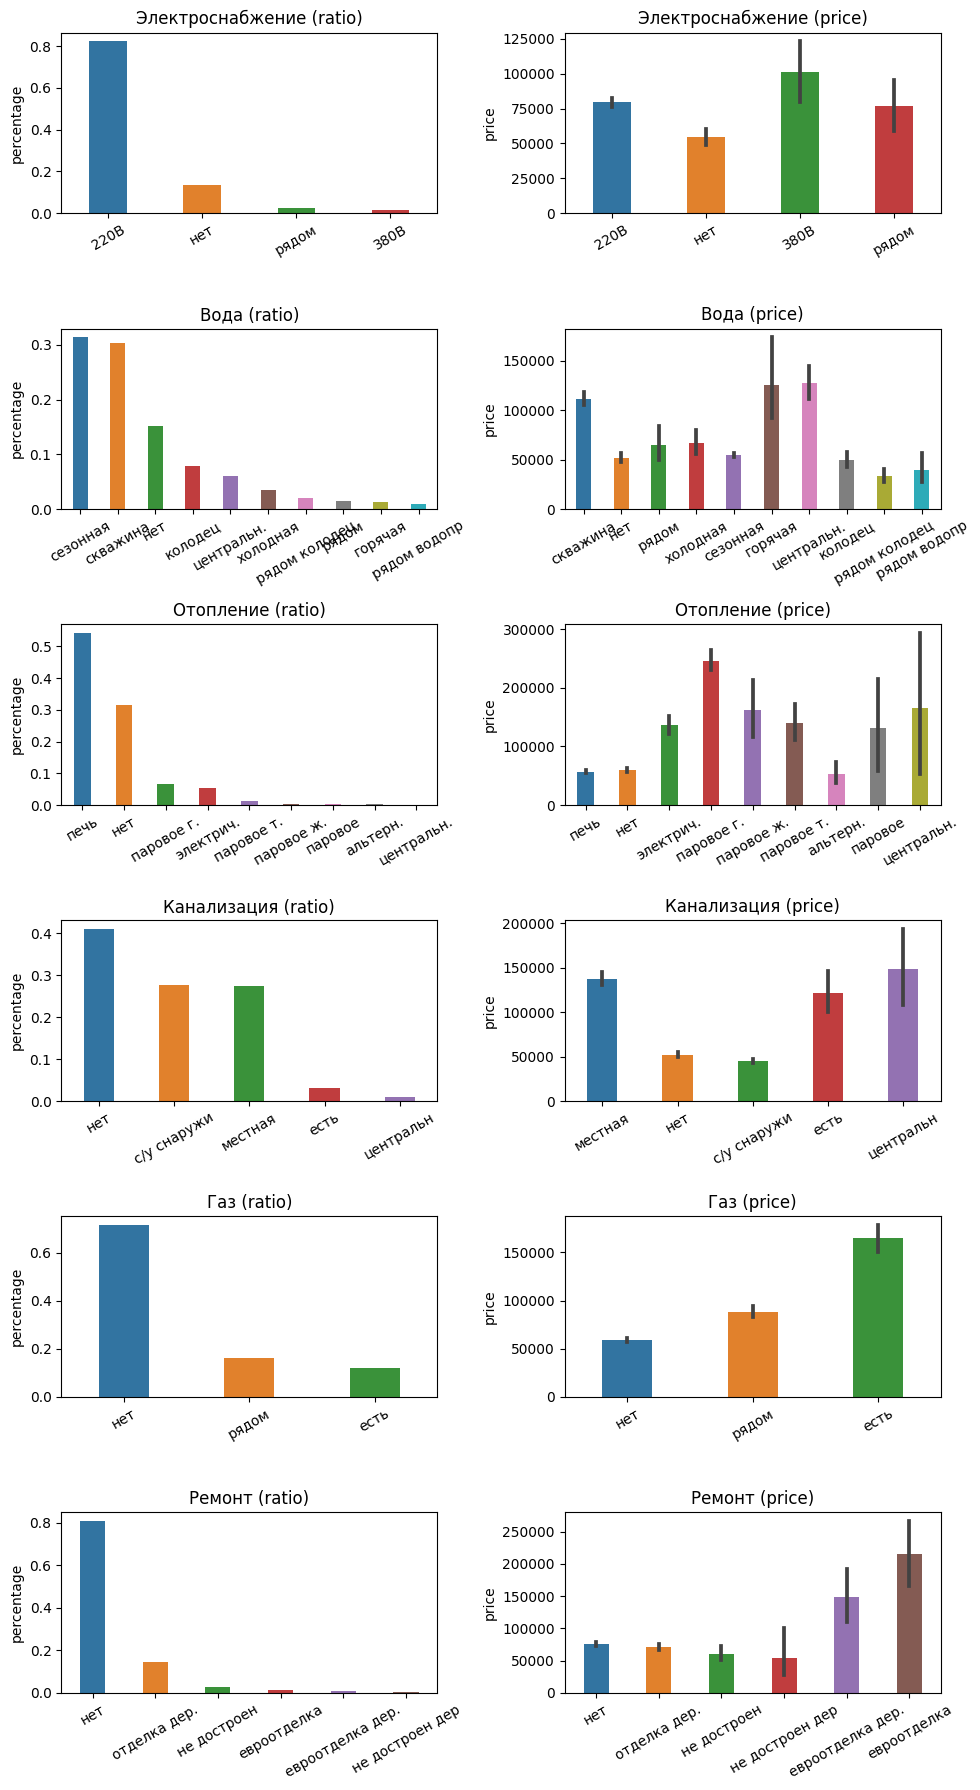

In [ ]:
draw_categories(fill_na_net)

In [ ]:
class CAT_2_Transformer(TransformerMixin, BaseEstimator):
    '''Transform categories with multiple values, supposed to be fillna with mode-value '''

    def __init__(self, fillna_cats):
        self.categories = fillna_cats
     
    def fit(self, X, y=None):
        ''''''
        return self

    def transform(self,X):
        ''''''
        X['Материал стен'] = X['Материал стен'].map({
            "['Дерево']":'дерево', 
            "['Кирпичный']":'кирпич', 
            "['Блок', 'газосиликатный']":'блок г/с', 
            "['Блочный']":'блок',
            "['Сборно-щитовой']":'сб-щитовой',
            "['Сруб']":'сруб',
            "['Дерево,', 'обложено', 'кирпичом']":'дер., кирпич',
            "['Белый', 'кирпич']":'кирпич бел.',
            "['Каркасный', 'деревянный']":'каркасн. дер.',
            "['Брус', 'профилированный']":'брус профил.',
            "['Каркасно-засыпной']":'каркасн. засыпн. ',
            "['Брус', 'оцилиндрованный']":'брус оцил.',
            "['Красный', 'кирпич']":'кирпич красн.',
            "['Облицовочный', 'кирпич']":'кирпич облиц.',
            "['Панельный']":'панельн.',
            "['Керамзитбетон']":'керамзитобетон',
            "['Шлакобетон']":'шлакобетон',
            "['Брус', 'клееный']":'брус клеен.',
            "['Монолитно-каркасный']":'каркасн. монол.'
            })

        X['Материал крыши'] = X['Материал крыши'].map({
            "['Шифер']":'шифер', 
            "['Металло-черепица']":'черепица мет.', 
            "['Ондулин']":'ондулин', 
            "['Металл']":'металл',
            "['Евро-шифер']":'е-шифер',
            "['Мягкая', 'черепица']":'черепица мяг.',
            "['Черепица']":'черепица',
            "['Битумная', 'черепица']":'черепица бит.',
            "['Жесть']":'жесть',
            "['Рубероид']":'рубероид',
            "['Гидроизоляция']":'гидроизоляция',
            "['Доски']":'доски',
            "['Природные', 'материалы']":'природн.'
            })

        X['Статус земли'] = X['Статус земли'].map({
            "['Частная']":'частная', 
            "['Пожизненноe', 'наследуемое', 'владение']":'пожизн.', 
            "['Другое']":'частная', 
            "['Аренда']":'аренда',
            })

        X[self.categories] = X[self.categories].fillna(X.mode().iloc[0])
        
        return X
    

cat_2_treat = CAT_2_Transformer(fill_na_mode)
df = cat_2_treat.transform(df)

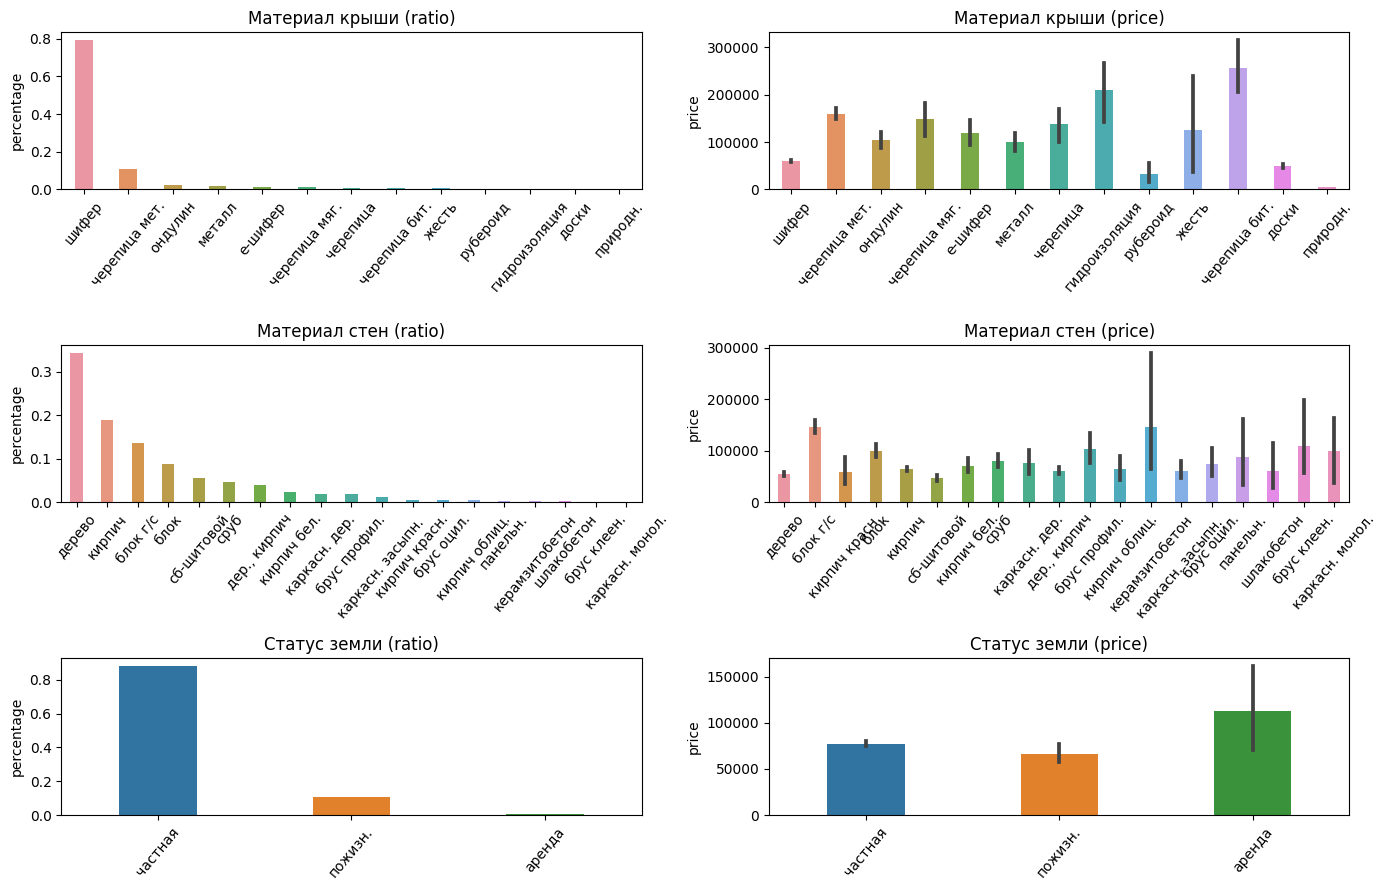

In [ ]:
draw_categories(['Материал крыши', 'Материал стен', 'Статус земли'], 14, 50)

In [ ]:
class CAT_3_Transformer(TransformerMixin, BaseEstimator):
    '''Transform categories with multiple values, supposed to be managed before fillna '''

    def __init__(self, fillna_cats):
        self.categories = fillna_cats
     
    def fit(self, X, y=None):
        ''''''
        return self

    def transform(self,X):
        ''''''
        X.loc[X[X['Населенный пункт']=="['г.', 'Минск']"].index,'Район'] = 'г.Минск'
        
        X['house_year'] = df['house_year'].fillna(df.groupby('Населенный пункт')['house_year'].transform(lambda x: x.mode()[0] if len(x.mode())>0 else np.nan))
        X['house_year'] = df['house_year'].fillna(df['house_year'].mode()[0])

        X['Область'] = X['Область'].map({
            "['Гомельская', 'область']":'Гомель', 
            "['Минская', 'область']":'Минск', 
            "['Гродненская', 'область']":'Гродно', 
            "['Брестская', 'область']":'Брест',
            "['Могилевская', 'область']":'Могилев',
            "['Витебская', 'область']":'Витебск'
            })
        
        def tryconvert(value):
            try:
                res = re.findall(r'\'(\w+)\'',value.replace('-',''))
                return res[0]
            except:
                return value
            
        
        X['Сельсовет'] = X['Сельсовет'].apply(lambda x: tryconvert(x))
        X['Сельсовет'] = X['Сельсовет'].fillna(X.groupby('Населенный пункт')['Сельсовет'].transform(lambda x: x.mode()[0] if len(x.mode())>0 else np.nan))
        X['Сельсовет'] = X['Сельсовет'].fillna('unknown')

        X['Район'] = X['Район'].apply(lambda x: tryconvert(x))
        
        #X[self.categories] = X[self.categories].fillna(X.mode().iloc[0])
        
        X.drop(['Направление'], axis=1, inplace=True)
        X = X[X['Район'].notna()]

        return X
    

cat_3_treat = CAT_3_Transformer(fill_na_find)
df = cat_3_treat.transform(df)

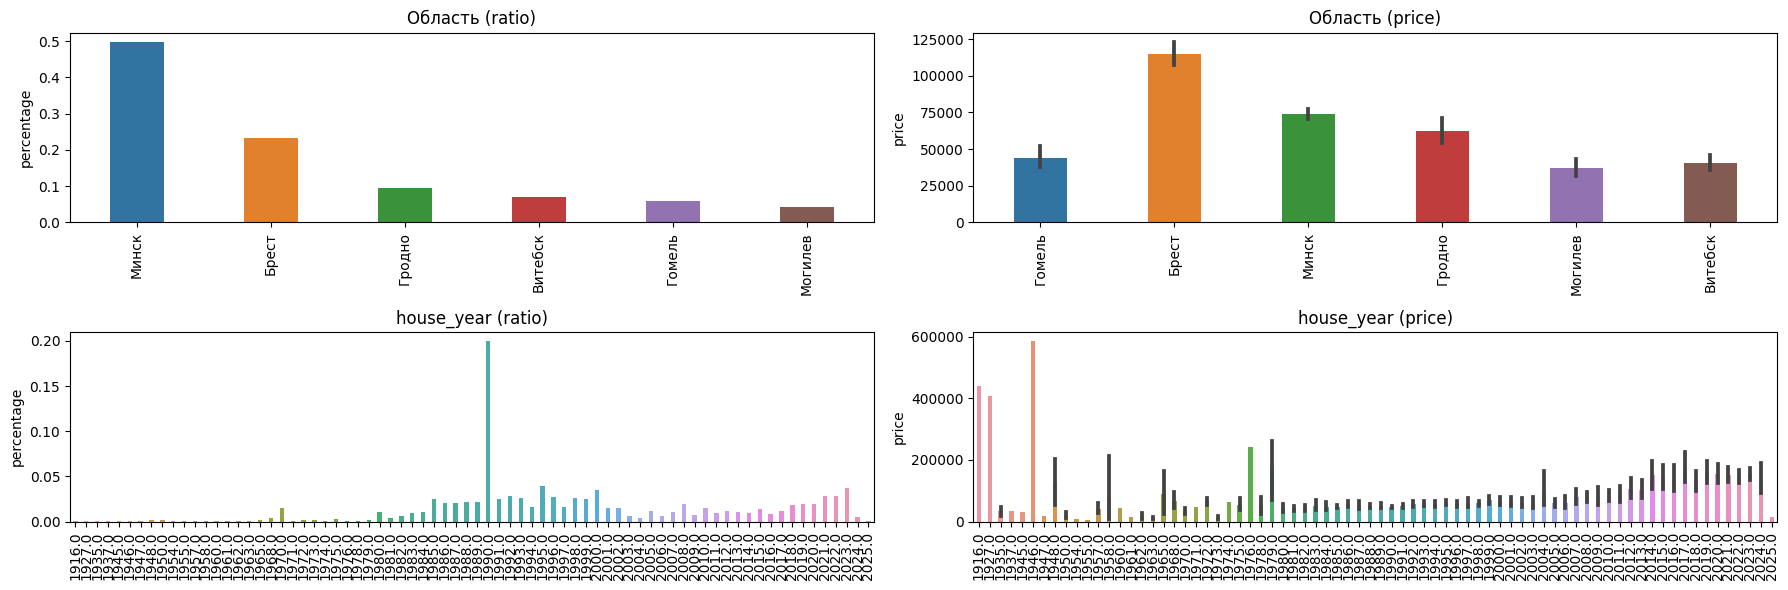

In [ ]:
draw_categories(['Область', 'house_year'], 18, 90)

In [ ]:
#temp = df['house_year'].isna()
#inds = temp[temp==True].index

#print(f"nan in 'house_year': {df['house_year'].isna().sum()}")
#df['house_year'] = df['house_year'].fillna(df.groupby('Населенный пункт')['house_year'].transform(lambda x: x.mode()[0] if len(x.mode())>0 else np.nan))
#print(f"nan after filling with city mode: {df['house_year'].isna().sum()}")
#df['year'] = df['year'].fillna(df.groupby('Район')['year'].transform(lambda x: x.mode()[0] if len(x.mode())>0 else np.nan))
#print(f"nan after filling with district mode: {df['year'].isna().sum()}")
#df['house_year'] = df['house_year'].fillna(df['house_year'].mode()[0])
#print(f"nan after filling with df mode: {df['house_year'].isna().sum()}")

#temp = df.groupby(['Населенный пункт', 'Район'])['house_year'].apply(lambda x: x.unique())
#temp

In [ ]:
#draw_categories(['house_year','house_levels'], 18, 90)

In [ ]:
from ipynb.fs.full.parsing_2 import get_district_details

district_dict = dict()


#for i in df['Район'].unique():
#    try:
#        district_dict[i] = get_district_details(i + ' район, Беларусь')
#    except:
#        print(i, "couldn't get data")
#        continue

#df_district = pd.DataFrame(district_dict, index=['district_center_coordinates', 'district_city_coordinates']).T
#df_district.to_csv('data/districts.csv')

In [ ]:
df_district = pd.read_csv('data/districts.csv')
df_district = df_district.rename(columns={'Unnamed: 0':'Район'})
df_district.head()

,Район,district_center_coordinates,district_city_coordinates
0,Гомельский,"(52.2527, 31.0048)","(52.263, 31.0)"
1,Брестский,"(52.0655, 23.394)","(52.0529, 23.4024)"
2,Молодечненский,"(54.1849, 26.5106)","(54.1849, 26.5106)"
3,Гродненский,"(53.4, 23.49)","(53.4, 23.49)"
4,Бобруйский,"(53.06, 29.13)","(53.06, 29.13)"


In [ ]:
dfc = pd.merge(df, df_district, how='left', on='Район')
dfc.head()

,Материал стен,Материал крыши,Отопление,Канализация,Электроснабжение,Вода,Телефон,Область,Район,Населенный пункт,...,house_year,house_readiness,house_coordinates,price,liv_house_area,kitchen_area,house_width,house_length,district_center_coordinates,district_city_coordinates
0,дерево,шифер,печь,местная,220В,скважина,1,Гомель,Гомельский,"['с/т', 'Родны', 'кут']",...,2000.0,100.0,"(52.330913, 30.814533)",9114.0,12.0,10.0,NaN,NaN,"(52.2527, 31.0048)","(52.263, 31.0)"
1,блок г/с,шифер,печь,местная,220В,скважина,0,Брест,Брестский,"['Знаменский', 'с/с']",...,1991.0,100.0,"(52.010669, 23.717579)",83003.0,43.1,7.2,NaN,NaN,"(52.0655, 23.394)","(52.0529, 23.4024)"
2,кирпич красн.,шифер,печь,нет,220В,нет,0,Минск,Молодечненский,"['с/т', 'АЛМАЗ-2002']",...,1990.0,100.0,"(54.389141, 26.682371)",41990.0,60.0,10.0,NaN,NaN,"(54.1849, 26.5106)","(54.1849, 26.5106)"
3,дерево,шифер,нет,нет,220В,нет,0,Брест,Брестский,"['с/т', 'Южное-2']",...,1994.0,100.0,"(52.071528, 23.786624)",56963.0,40.0,10.0,NaN,NaN,"(52.0655, 23.394)","(52.0529, 23.4024)"
4,блок,шифер,нет,нет,нет,нет,0,Гродно,Гродненский,"['с/т', 'Колос-Жиличи']",...,1995.0,100.0,"(53.620568, 23.984891)",35805.0,40.0,10.0,NaN,NaN,"(53.4, 23.49)","(53.4, 23.49)"


In [ ]:
#df['district_center_coordinates'] = df['Район'].apply(lambda x: district_dict[x] if x in district_dict else district_dict['Минский'])
#dfc['city_coordinates'] = dfc.apply(lambda x: (x.latitude_x, x.longitude_x), axis=1)
#dfc['district_center_coordinates'] = dfc.apply(lambda x: (float(x.latitude), float(x.longitude)), axis=1)
#dfc.loc[dfc['Населенный пункт']=="['г.', 'Минск']",'district_center_coordinates'] = str(regions_dict['Минск'])

#dfc.drop(['latitude', 'longitude',], axis=1, inplace=True)
dfc.to_csv('data/country_houses_treated.csv')

In [ ]:
dfc = pd.read_csv('data/country_houses_treated.csv', index_col=0)
dfc.tail(3)

,Материал стен,Материал крыши,Отопление,Канализация,Электроснабжение,Вода,Телефон,Область,Район,Населенный пункт,...,house_year,house_readiness,house_coordinates,price,liv_house_area,kitchen_area,house_width,house_length,district_center_coordinates,district_city_coordinates
2938,дерево,шифер,нет,нет,нет,колодец,0,Гродно,Гродненский,"['с/т', 'Демидково']",...,2010.0,100.0,"(53.522132, 23.790479)",10416.0,40.0,10.0,NaN,NaN,"(53.4, 23.49)","(53.4, 23.49)"
2939,каркасн. дер.,е-шифер,печь,есть,220В,колодец,0,Минск,Воложинский,"['с/т', 'Западная', 'Березина']",...,2019.0,100.0,"(54.117371, 26.437489)",21158.0,40.0,10.0,NaN,NaN,"(54.05, 26.31)","(54.05, 26.31)"
2940,блок г/с,черепица мет.,нет,местная,рядом,скважина,0,Брест,Брестский,"['с/т', 'Зеленый', 'бор']",...,2022.0,100.0,"(52.042633, 23.760319)",170888.0,40.0,10.0,NaN,NaN,"(52.0655, 23.394)","(52.0529, 23.4024)"


### New features

In [ ]:
def get_location(name):
    try:
        g = geocoder.bing(name, key='AgY4Qy8qL2I1oMf6xu6SSpqncKEFzpjZIKzs3Y_lhKvdA4cRPMUpBEIDmgXxm5_e')
        results = g.json
        #print(name, results['lat'], results['lng'])
        return (results['lat'], results['lng'])
    except:
        print('exception', name)
        return name


regions_dict = dict()
regions = df['Область'].unique()
for item in regions:
    if type(item) is str:
        regions_dict[item] = get_location(item + ', беларусь')
    else:
        continue


dfc['regional_center_coordinates'] = dfc['Область'].apply(lambda x: str(regions_dict[x]) )

In [ ]:
def get_distance(d1,d2):
    coord1 = d1.replace(',',' ').lstrip('(').rstrip(')').split()
    coord2 = d2.replace(',',' ').lstrip('(').rstrip(')').split()
    return geopy.distance.geodesic((float(coord1[0]),float(coord1[1])), (float(coord2[0]),float(coord2[1]))).km

dfc['distance_house_district'] = dfc.apply(lambda x: get_distance(x['house_coordinates'], x['district_center_coordinates']), axis=1)
dfc['distance_house_region'] = dfc.apply(lambda x: get_distance(x['house_coordinates'], x['regional_center_coordinates']), axis=1)
dfc['distance_house_minsk'] = dfc.apply(lambda x: get_distance(x['house_coordinates'], str(regions_dict['Минск'])), axis=1)

dfc.loc[400:410, ['Населенный пункт','Район','distance_house_district',  'distance_house_region','distance_house_minsk']]



,Населенный пункт,Район,distance_house_district,distance_house_region,distance_house_minsk
400,"['с/т', 'Ольха-91']",Брестский,29.285679,27.639759,347.787463
401,"['с/т', 'Сутоки']",Смолевичский,20.501229,48.500760,48.500760
402,"['с/т', 'Елочка']",Червенский,39.519861,32.543176,32.543176
403,"['д.', 'Новая', 'Милеевка']",Могилевский,23.478249,20.587463,188.975308
404,"['с/т', 'Асвета']",Пуховичский,12.006293,71.864257,71.864257
405,"['Мухавецкий', 'с/с']",Брестский,30.427341,9.874946,324.650963
406,"['Воложинский', 'с/с']",Воложинский,57.383557,27.225478,27.225478
407,"['д.', 'Веречье']",Городокский,58.991903,45.443409,260.435535
408,"['д.', 'Николаевка', '3']",Могилевский,44.383774,4.595543,187.536243
409,"['Мухавецкий', 'с/с']",Брестский,30.427341,9.874946,324.650963


In [ ]:
dfc = dfc.drop(['house_length', 'house_width'], axis=1)
#dfc = dfc.drop(['regional_center_coordinates', 'district_center_coordinates', 'house_coordinates', 'Населенный пункт'], axis=1)


In [ ]:
dfc.corr(numeric_only=True)['price'].sort_values(ascending=False)

price                      1.000000
house_year                 0.395114
liv_house_area             0.363869
house_area                 0.327029
kitchen_area               0.316157
Элитный коттедж            0.167000
distance_house_minsk       0.119812
Новостройка                0.097997
Камин                      0.082700
Бассейн                    0.077565
Беседка                    0.061778
distance_house_district    0.046538
Телефон                    0.043705
house_readiness            0.042659
Баня                       0.035012
Пруд на участке            0.002927
land_area                 -0.002171
Гараж                     -0.009463
Мебель                    -0.023207
Строительные материалы    -0.029508
house_levels              -0.037388
Теплица                   -0.046475
Ландшафтный дизайн        -0.049201
Водоем                    -0.081926
Хозпостройки              -0.112039
Сад                       -0.132097
Рядом лес                 -0.148621
distance_house_region     -0

<AxesSubplot: >

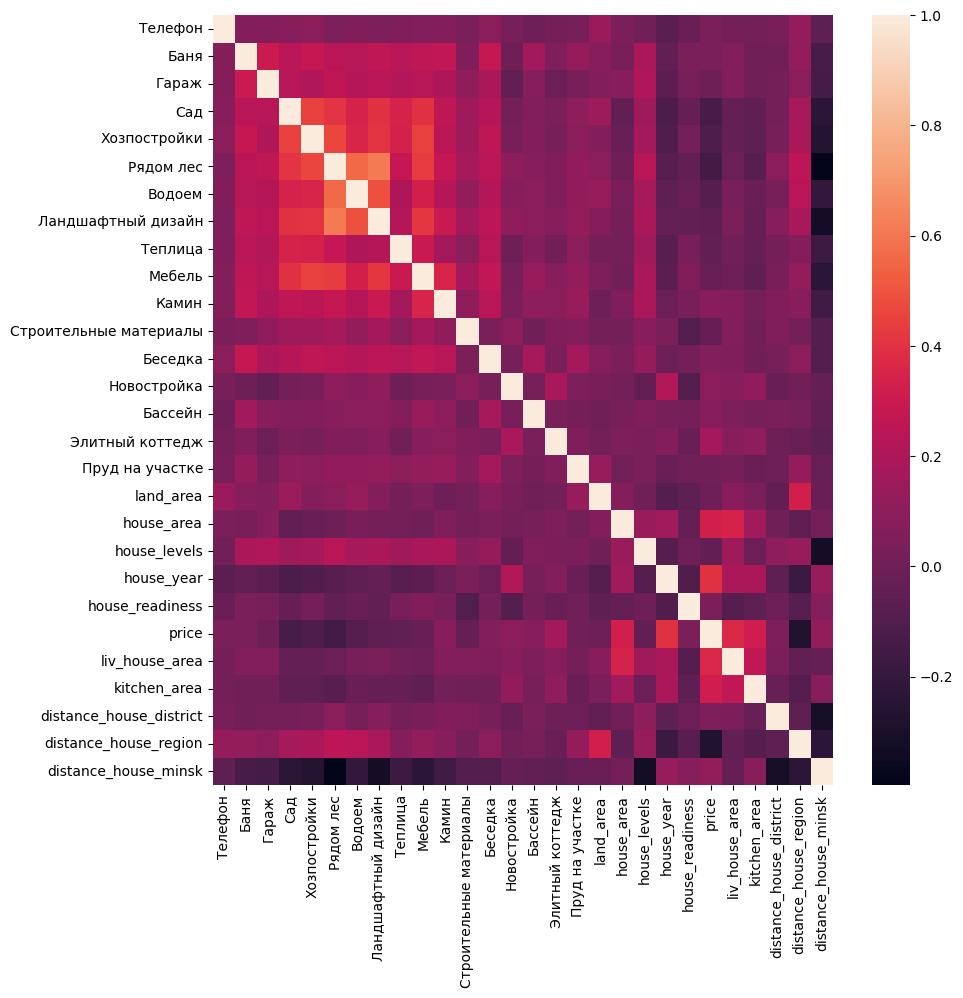

In [ ]:
f,a = plt.subplots(figsize=(10,10))
sns.heatmap(dfc.corr(numeric_only=True))

In [ ]:
ohe_list = ['Материал стен', 'Материал крыши', 'Отопление', 'Канализация', 'Электроснабжение', 'Вода','Область', 'Район', 'Газ', 'Статус земли', 'Ремонт']

encoder = ce.OneHotEncoder(cols=ohe_list, use_cat_names=True)
add = encoder.fit_transform(dfc.loc[:,ohe_list])
dff = pd.concat([dfc,add], axis=1)


In [ ]:
dff = dff.drop(ohe_list, axis=1)
dff = dff.drop(['house_coordinates','regional_center_coordinates','district_center_coordinates', 'district_city_coordinates', 'Населенный пункт', 'Сельсовет'], axis=1)
dff.head(3)

,Телефон,Баня,Гараж,Сад,Хозпостройки,Рядом лес,Водоем,Ландшафтный дизайн,Теплица,Мебель,...,Газ_есть,Статус земли_частная,Статус земли_пожизн.,Статус земли_аренда,Ремонт_нет,Ремонт_отделка дер.,Ремонт_не достроен,Ремонт_не достроен дер,Ремонт_евроотделка дер.,Ремонт_евроотделка
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,0,1,1,1,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
2,0,0,1,0,0,1,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0


### Models

In [ ]:
X = dff.drop('price', axis=1)
y = dff['price']

scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=40)

print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (2352, 197)
Test shape: (589, 197)


In [ ]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Test MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

In [ ]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.699
Train MAE: 28585.876
Train MAPE: 63.827


Test R^2: -12037234693375042519040.000
Test MAE: 777701437591866.875
Test MAPE: 8246949965477.199


In [ ]:
sgdr = linear_model.SGDRegressor(random_state=40)
sgdr.fit(X_train, y_train)

y_train_pred = sgdr.predict(X_train)
y_test_pred = sgdr.predict(X_test)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.669
Train MAE: 29503.123
Train MAPE: 65.609


Test R^2: 0.557
Test MAE: 30430.685
Test MAPE: 113.731


In [ ]:
X = df.loc[:,['latitude', 'longitude']]

def get_silhouette(cluster_num, X):
    k_means =  KMeans(n_clusters=cluster_num, random_state=42, n_init='auto')
    k_means.fit(X)
    silhouette = silhouette_score(X, k_means.labels_)
    inertia = k_means.inertia_
    return silhouette, inertia

interv = range(2,20)
silhouette = {x:0 for x in interv}
inertia = {x:0 for x in interv}
for num in interv:
    silhouette[num] = (get_silhouette(num, X)[0])
    inertia[num] = (get_silhouette(num, X)[1])

#f,a = plt.subplots(1,2,figsize=(8,5))
#sns.lineplot(x=interv, y=silhouette.values(), ax=a[0]).set(title='silhouette score', xlabel='cluster qty');
#sns.lineplot(x=interv, y=inertia.values(), ax=a[1]).set(title='inertia', xlabel='cluster qty');

k_means =  KMeans(n_clusters=9, random_state=42, n_init='auto')
k_means.fit(X)

df_labels = pd.Series(k_means.labels_)
df['cluster'] = k_means.labels_
#df_labels.value_counts()

#f,a = plt.subplots(figsize=(8,8))
#sns.scatterplot(df, x='latitude', y='longitude', hue='cluster', palette='colorblind', s=10);


color_scale = [(0, 'orange'), (1,'red')]

fig = px.scatter_mapbox(df, 
                        lat="latitude", 
                        lon="longitude", 
                        #hover_name="Address", 
                        #hover_data=["Address", "Listed"],
                        #color="Listed",
                        color_continuous_scale=color_scale,
                        #size="Listed",
                        zoom=8, 
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

KeyError: "None of [Index(['latitude', 'longitude'], dtype='object')] are in the [columns]"